In [1]:
from numpy import array
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

from pyspark import SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel

In [2]:
sc = SparkContext()

In [3]:
# Load and parse the data
data = sc.textFile('./lastfm-dataset-360k-small/merged-subset2.csv')
data.take(2)

['userId\tartistId\tartist\tplays\tgender\tage\tcountry\tsignupDate',
 '03b9c645bc4f578ea1dcb6a975e7ea71fab79da2\ta16371b9-7d36-497a-a9d4-42b0a0440c5e\tslowdive\t0.08359133126934984\tm\t28.0\tGermany\t2006-09-16']

How the data should look like - [array([ 0.,  0.,  0.]), array([ 0.1,  0.1,  0.1])]

### Make a list from every line

In [4]:
data = data.map(lambda x: x.split('\t'))
header = data.first()

### Clean Data

In [5]:
#Remove header
data2 = data.filter(lambda line: line!=header)
# x[3] --> plays/day; x[4] --> gender; x[5] --> age; x[6] --> Country
print ("length of uncleaned data -",data2.count())
# data2.map(lambda x : len(x[1])).collect()
# data2 = data2.filter(lambda x : len(x[1]) == 36) #Clean data - remove artists without artistId

length of uncleaned data - 10000


In [6]:
data2.first()

['03b9c645bc4f578ea1dcb6a975e7ea71fab79da2',
 'a16371b9-7d36-497a-a9d4-42b0a0440c5e',
 'slowdive',
 '0.08359133126934984',
 'm',
 '28.0',
 'Germany',
 '2006-09-16']

### Filter the data

In [7]:
# data2.map(lambda x: x[4]).filter(lambda x: len(x) != 1).count()
# data2.map(lambda x: x[5]).filter(lambda x: len(x) < 1).count()
# data2.map(lambda x: x[6]).filter(lambda x: len(x) < 1).count()

data3 = data2.filter(lambda x: (len(x[4]) == 1) & (len(x[5]) > 1))
data3.count()

7492

### Encode the data

In [8]:
genderdict = {'m':0,'f':1}

countrylist = ['United States', 'Germany', 'United Kingdom', 'Poland', 'Russian Federation', 'Brazil', 'Sweden', 'Spain', 'Finland', 'Netherlands', 'Italy', 'France', 'Canada', 'Australia', 'Turkey', 'Norway', 'Czech Republic', 'Ukraine', 'Japan', 'Belgium', 'Mexico', 'Argentina', 'Switzerland', 'Austria', 'Romania', 'Portugal', 'Bulgaria', 'Chile', 'Denmark', 'Colombia', 'Greece', 'Hungary', 'Latvia', 'Slovakia', 'Croatia', 'Serbia', 'Lithuania', 'Estonia', 'Ireland', 'New Zealand', 'Belarus', 'Israel', 'India', 'Venezuela', 'Indonesia', 'Singapore', 'Slovenia', 'Korea, Republic of', 'China', 'South Africa', 'Malaysia', 'Philippines', 'Peru', 'Thailand', 'Moldova', 'Costa Rica', 'Iceland', 'Taiwan', 'Paraguay', 'Bosnia and Herzegovina', 'Antarctica', 'Puerto Rico', 'Georgia', 'Macedonia', 'Uruguay', 'Honduras', 'Barbados', 'Kazakhstan', 'Andorra', 'Saudi Arabia', 'United States Minor Outlying Islands', 'Djibouti', 'Cocos (Keeling) Islands', 'Tunisia', 'Egypt', 'Bolivia', 'Panama', 'Brunei Darussalam', 'Iran, Islamic Republic of', 'Dominican Republic', 'El Salvador', 'Haiti', 'Ecuador', 'Guatemala', 'Morocco', 'Pakistan', 'Burkina Faso', 'Azerbaijan', 'Cambodia', 'Hong Kong', 'Viet Nam', 'United Arab Emirates', 'Jamaica', 'Faroe Islands', 'Somalia', 'Guinea-Bissau', 'Micronesia, Federated States of', 'Tuvalu', "Cote D'Ivoire", 'Libyan Arab Jamahiriya', 'Nicaragua', 'Kyrgyzstan', 'Malta', 'Bermuda', 'Luxembourg', 'Kuwait', 'Cyprus', 'Heard Island and Mcdonald Islands', 'Christmas Island', 'Cuba', 'Niue', 'Aruba', 'Vanuatu', 'Dominica', 'Holy See (Vatican City State)', 'Uzbekistan', 'Bhutan', 'Montenegro', 'Reunion', 'Fiji', 'Netherlands Antilles', 'Lebanon', 'Liechtenstein']
countrydict = dict(zip(countrylist, [i for i in range(len(countrylist))]))
# print(countrydict)

# Define a mapper functions
def mapr1(key):
    """ Maps numbers to categories (gender)"""
    return genderdict[key]

def mapr2(key):
    """ Maps numbers to categories (country)"""
    return countrydict[key]

In [9]:
data4 = data3.map(lambda x: [mapr1(x[4]), float(x[5]), mapr2(x[6])])

data4.count()

7492

### Clustering

In [10]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [11]:
# Build the model (cluster the data)
kdict = dict.fromkeys(range(2,50)) #initialize dictionary with user_id keys
for k in kdict.keys():
    clusters = KMeans.train(data4, k, maxIterations=100, initializationMode="kmeans||")
#     print (k)
    WSSSE = data4.map(lambda point: error(point)).reduce(lambda x, y: x + y) #Within Cluster Sum of Squares
    kdict[k] = WSSSE
# print("Within Set Sum of Squared Error = " + str(WSSSE))

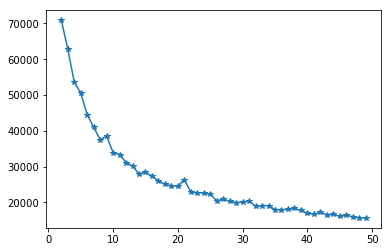

In [12]:
plt.plot(list(kdict.keys()),list(kdict.values()), '*-')

In [13]:
k = 10 # number of clusters
clusters = KMeans.train(data4, kbest, maxIterations=100, initializationMode="kmeans||")
WSSSE = data4.map(lambda point: error(point)).reduce(lambda x, y: x + y) #Within Cluster Sum of Squares
print(WSSSE)

34283.92645787765


In [14]:
data.take(2)

[['userId',
  'artistId',
  'artist',
  'plays',
  'gender',
  'age',
  'country',
  'signupDate'],
 ['03b9c645bc4f578ea1dcb6a975e7ea71fab79da2',
  'a16371b9-7d36-497a-a9d4-42b0a0440c5e',
  'slowdive',
  '0.08359133126934984',
  'm',
  '28.0',
  'Germany',
  '2006-09-16']]

In [15]:
clusters.predict([ 0,  28,  67])

3

In [31]:
# output = parsedData.map(lambda i: [i, clusters.predict(i)])
output = data3.map(lambda x: [x, clusters.predict([mapr1(x[4]), float(x[5]), mapr2(x[6])])])

In [17]:
# output.take(10)
a = np.empty((5,10))

In [18]:
# a[0,:] = [5,2,4,1,3,8,9,7,0,6]
# a.sort()
a[0,:]

array([  4.61986920e+281,   7.10004881e-154,   2.19529496e-152,
         1.14974967e+171,   2.05132425e+161,   2.02439631e-258,
         1.32108724e+272,   3.41903149e+228,   3.44568507e+228,
         3.30804647e-027])

In [19]:
for j in range(5):
    for i in range(10):
        clusters = KMeans.train(data4, kbest, maxIterations=100, initializationMode="kmeans||")
        output = data4.map(lambda i: [i, clusters.predict(i)])
        a[j,i] = output.filter(lambda x: x[1] == i).count()

In [20]:
a.sort()
a #Visualize the cluster sizes formed through each iteration

array([[   33.,    35.,   173.,   325.,   389.,   410.,   420.,   551.,
          764.,  1446.],
       [   29.,    55.,    57.,   324.,   387.,   683.,  1271.,  1345.,
         2543.,  2710.],
       [   12.,   134.,   183.,   381.,   464.,   749.,   781.,  1275.,
         1297.,  2102.],
       [  397.,   427.,   444.,   488.,   631.,  1264.,  1305.,  1345.,
         1719.,  2849.],
       [   34.,    36.,    74.,   127.,   263.,   433.,   445.,   459.,
          741.,  3126.]])

In [21]:
#save the model
clusters.save(sc, "./model/clustering1")

### Determine top 20 artists for every cluster

In [64]:
for i in range(k):
    summation = output.filter(lambda x: x[1] == 0).map(lambda x: (x[0][1], float(x[0][3]))).reduceByKey(lambda x,y : x+y)
    count = output.filter(lambda x: x[1] == 0).map(lambda x: (x[0][1], 1)).reduceByKey(lambda x,y : x+y)
    average = summation.join(count).map(lambda x: (x[0], x[1][0]/x[1][1]))

[('d7ac3cc7-0d65-476b-9b81-d3e872672a2f', 0.9721869110940131),
 ('592b9a1b-b900-4c1a-a165-bd7e7ce87d23', 0.20020534984733152)]

In [63]:
average.take(2)

[('d7ac3cc7-0d65-476b-9b81-d3e872672a2f', (0.9721869110940131, 2)),
 ('592b9a1b-b900-4c1a-a165-bd7e7ce87d23', (0.20020534984733152, 2))]

In [72]:
average.map(lambda x: (x[1],x[0])).sortByKey(0, 1).map(lambda x: (x[1],x[0])).take(20)

[('c3cceeed-3332-4cf0-8c4c-bbde425147b6', 5.796116504854369),
 ('b7ffd2af-418f-4be2-bdd1-22f8b48613da', 4.2894736842105265),
 ('ebfc1398-8d96-47e3-82c3-f782abcdb13d', 3.7221324717285946),
 ('42689657-cbec-4f66-a9ed-80f939ea23ed', 3.4745762711864407),
 ('55b92a4f-34eb-4d89-8f84-75812c804ab4', 2.4459567654123298),
 ('487bfd74-71bf-46dd-b89c-80b7a0f06f2f', 2.3873873873873874),
 ('f82bcf78-5b69-4622-a5ef-73800768d9ac', 2.3535353535353534),
 ('1c3919b2-43ca-4a4a-935d-9d50135ec0ef', 2.2062326322925747),
 ('06aaeca4-2008-4e48-a2bf-119f3d363b4f', 1.9978213507625273),
 ('cb9b28ec-799f-44d8-a0b2-2eee3e8eb5b1', 1.839907192575406),
 ('7bbfd77c-1102-4831-9ba8-246fb67460b3', 1.82996803343686),
 ('067102ea-9519-4622-9077-57ca4164cfbb', 1.6213201575921978),
 ('125948ec-7f91-4d1a-8b83-accbf50fae3d', 1.597139451728248),
 ('17167af8-c1da-45cc-bba2-9d23f068b7a3', 1.5411431861131246),
 ('8c538f11-c141-4588-8ecb-931083524186', 1.5105189679065973),
 ('674a7e8c-9682-419a-8e05-2358e28b5359', 1.466878313908609)